In [1]:
push!(LOAD_PATH, "./")
using Plots
using Bspline
using FastGaussQuadrature
using LinearAlgebra
using WriteVTK

┌ Info: Precompiling Bspline [top-level]
└ @ Base loading.jl:1278


In [2]:
function INT(f,a,b,nip) # 被積分関数f，区間[a,b]，積分点の個数nipを引数にとり，積分値を返す
    nodes,weights = gausslegendre(nip)
    nodes = nodes*(b-a)/2.0.+(a+b)/2.0
    return (b-a)/2*sum(weights[i]*f(nodes[i]) for i in 1:nip)
end

# B-spline関数のリファインメント
function pref(pi,p,k)    # pi:リファインメント前の次数, p:リファインメント後の次数
    l = k[1]
    r = k[end]
    n = p-pi
    prepend!(k,[l for i in 1:n])
    append!(k,[r for i in 1:n])
end
function href(p,k,N)    # N:リファインメント後の基底関数の個数
    for i in 1:N-p-1
        insert!(k,p+1+i,i/(N-p))
    end
end

href (generic function with 1 method)

In [24]:
# 初期の基底関数
p1i = 1
p2i = 1
k1i = [0.0, 0.0, 1.0, 1.0]
k2i = [0.0, 0.0, 1.0, 1.0]
N1i = length(k1i)-p1i-1
N2i = length(k2i)-p2i-1
Ni = N1i*N2i

# 初期の制御点
ai = zeros(Float64,2,Ni) # ai[次元,α]
ai[1,:] = [0.0, 0.0, 10.0, 10.0]    # x1座標の値
ai[2,:] = [0.0, 1.0, 0.0, 1.0]    # x2座標の値

4-element Array{Float64,1}:
 0.0
 1.0
 0.0
 1.0

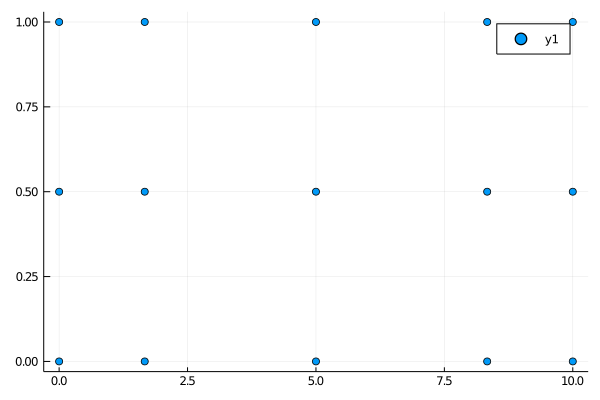

In [25]:
# リファインメント後の基底関数
p1 = 2
p2 = 2
k1 = copy(k1i)
k2 = copy(k2i)
N1 = 5  # 1軸方向の基底関数の個数
N2 = 3  # 2軸方向の基底関数の個数
N = N1*N2    # 1,2軸方向の基底関数の組み合わせの数
pref(p1i,p1,k1)
pref(p2i,p2,k2)
href(p1,k1,N1)
href(p2,k2,N2)

# リファインメント後の制御点を求める
C1 = zeros(Float64,(N1,N1i))
C2 = zeros(Float64,(N2,N2i))
κ1 = [k1[j]*(N1-j)/(N1+1)+k1[j+p1+1]*(j+1)/(N1+1) for j in 1:N1]
κ2 = [k2[j]*(N2-j)/(N2+1)+k2[j+p2+1]*(j+1)/(N2+1) for j in 1:N2]
B1i = [Bs(j,p1i,k1i,κ1[i]) for i in 1:N1, j in 1:N1i]
B2i = [Bs(j,p2i,k2i,κ2[i]) for i in 1:N2, j in 1:N2i]
B1 = [Bs(j,p1,k1,κ1[i]) for i in 1:N1, j in 1:N1]
B2 = [Bs(j,p2,k2,κ2[i]) for i in 1:N2, j in 1:N2]
C1 = inv(B1)*B1i
C2 = inv(B2)*B2i
a = zeros(Float64,(2,N))
a0 = zeros(Float64,(2,N))
for α in 1:N
    α1 = div(α-1,N2)+1
    α2 = (α-1)%N2+1
    for αi in 1:Ni
        α1i = div(αi-1,N2i)+1
        α2i = (αi-1)%N2i+1
        
        a[1,α] += C1[α1,α1i]*C2[α2,α2i]*ai[1,αi]
        a[2,α] += C1[α1,α1i]*C2[α2,α2i]*ai[2,αi]
    end
end
a0 = copy(a)
plot(a[1,:],a[2,:], seriestype=:scatter)

In [5]:
# 剛性行列
λ = 122.0e3
μ = 79.0e3
J1 = 10.0
J2 = 1.0
detJ = 10.0
nip = 2    # 積分点の数 (p1+1)/2以上
K11 = zeros(Float64,(N,N))
K22 = zeros(Float64,(N,N))
K12 = zeros(Float64,(N,N))
K21 = zeros(Float64,(N,N))
for α in 1:N
    for β in 1:N
        α1 = div(α-1,N2)+1    # 1軸方向の基底関数の番号
        α2 = (α-1)%N2+1    # 2軸方向の基底関数の番号
        β1 = div(β-1,N2)+1    # 1軸方向の基底関数の番号
        β2 = (β-1)%N2+1    # 2軸方向の基底関数の番号
        
        c11_1 = sum(INT(t->Ḃs(α1,p1,k1,t)*Ḃs(β1,p1,k1,t),k1[m],k1[m+1],nip) for m in 1:length(k1)-1)
        c11_2 = sum(INT(t->Bs(α2,p2,k2,t)*Bs(β2,p2,k2,t),k2[m],k2[m+1],nip) for m in 1:length(k2)-1)
        c11_3 = sum(INT(t->Bs(α1,p1,k1,t)*Bs(β1,p1,k1,t),k1[m],k1[m+1],nip) for m in 1:length(k1)-1)
        c11_4 = sum(INT(t->Ḃs(α2,p2,k2,t)*Ḃs(β2,p2,k2,t),k2[m],k2[m+1],nip) for m in 1:length(k2)-1)
        K11[α,β] = (λ+2μ)/(J1^2)*c11_1*c11_2*detJ + μ/(J2^2)*c11_3*c11_4*detJ
        
        c22_1 = sum(INT(t->Bs(α1,p1,k1,t)*Bs(β1,p1,k1,t),k1[m],k1[m+1],nip) for m in 1:length(k1)-1)
        c22_2 = sum(INT(t->Ḃs(α2,p2,k2,t)*Ḃs(β2,p2,k2,t),k2[m],k2[m+1],nip) for m in 1:length(k2)-1)
        c22_3 = sum(INT(t->Ḃs(α1,p1,k1,t)*Ḃs(β1,p1,k1,t),k1[m],k1[m+1],nip) for m in 1:length(k1)-1)
        c22_4 = sum(INT(t->Bs(α2,p2,k2,t)*Bs(β2,p2,k2,t),k2[m],k2[m+1],nip) for m in 1:length(k2)-1)
        K22[α,β] = (λ+2μ)/(J2^2)*c22_1*c22_2*detJ + μ/(J1^2)*c22_3*c22_4*detJ 
        
        c12_1 = sum(INT(t->Ḃs(α1,p1,k1,t)*Bs(β1,p1,k1,t),k1[m],k1[m+1],nip) for m in 1:length(k1)-1)
        c12_2 = sum(INT(t->Bs(α2,p2,k2,t)*Ḃs(β2,p2,k2,t),k2[m],k2[m+1],nip) for m in 1:length(k2)-1)
        c12_3 = sum(INT(t->Bs(α1,p1,k1,t)*Ḃs(β1,p1,k1,t),k1[m],k1[m+1],nip) for m in 1:length(k1)-1)
        c12_4 = sum(INT(t->Ḃs(α2,p2,k2,t)*Bs(β2,p2,k2,t),k2[m],k2[m+1],nip) for m in 1:length(k2)-1)
        K12[α,β] = λ/(J1*J2)*c12_1*c12_2*detJ + μ/(J1*J2)*c12_3*c12_4*detJ
        
        c21_1 = sum(INT(t->Bs(α1,p1,k1,t)*Ḃs(β1,p1,k1,t),k1[m],k1[m+1],nip) for m in 1:length(k1)-1)
        c21_2 = sum(INT(t->Ḃs(α2,p2,k2,t)*Bs(β2,p2,k2,t),k2[m],k2[m+1],nip) for m in 1:length(k2)-1)
        c21_3 = sum(INT(t->Ḃs(α1,p1,k1,t)*Bs(β1,p1,k1,t),k1[m],k1[m+1],nip) for m in 1:length(k1)-1)
        c21_4 = sum(INT(t->Bs(α2,p2,k2,t)*Ḃs(β2,p2,k2,t),k2[m],k2[m+1],nip) for m in 1:length(k2)-1)
        K21[α,β] = λ/(J1*J2)*c21_1*c21_2*detJ + μ/(J1*J2)*c21_3*c21_4*detJ
    end
end

In [6]:
K = zeros(Float64,(2N,2N))
for i in 1:2N
    for j in 1:2N
        α = div(i-1,2)+1
        β = div(j-1,2)+1
        αflag = (i-1)%2+1
        βflag = (j-1)%2+1
        if αflag==1 && βflag==1
            K[i,j] = K11[α,β]
        elseif αflag==2 && βflag==2
            K[i,j] = K22[α,β]
        elseif αflag==1 && βflag==2
            K[i,j] = K12[α,β]
        elseif αflag==2 && βflag==1
            K[i,j] = K21[α,β]
        end
    end
end

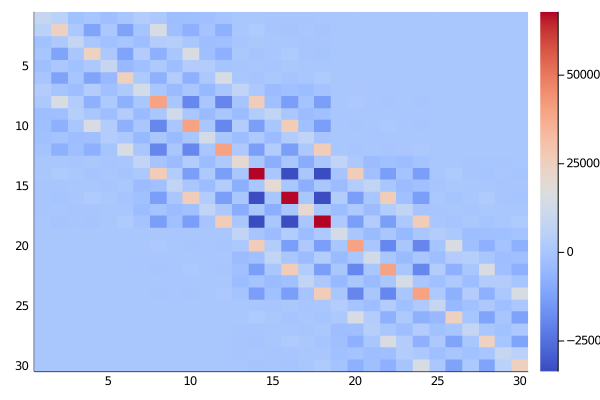

In [7]:
heatmap(K,yflip=true,color=:coolwarm)

In [8]:
# 右辺ベクトル
g = [0.0,-10.0]
detJsurface = 1.0 # 右端(1次元)の座標変換なので、Jsurface = 1となり行列式も1となる
b = zeros(Float64,2N)
for idx in 1:2N
    β = div(idx-1,2)+1
    i = (idx-1)%2+1
    β1 = div(β-1,N2)+1
    β2 = (β-1)%N2+1
    b_0(t) = g[i]*Bs(β1,p1,k1,1.0)*Bs(β2,p2,k2,t)*detJsurface
    b[idx] = sum(INT(b_0,k2[m],k2[m+1],nip) for m in β2:β2+p2)
end
b

30-element Array{Float64,1}:
  0.0
 -0.0
  0.0
 -0.0
  0.0
 -0.0
  0.0
 -0.0
  0.0
 -0.0
  0.0
 -0.0
  0.0
  ⋮
  0.0
 -0.0
  0.0
 -0.0
  0.0
 -0.0
  0.0
 -3.3333333333333335
  0.0
 -3.333333333333333
  0.0
 -3.333333333333333

In [ ]:
# Dirichlet境界条件を負荷
# 右辺ベクトル
U = [0.0,0.0]    # Dirichlet境界条件の変位
for idx in 1:2N2
    i = (idx-1)%2+1
    b[idx] = U[i]
end
for idx in 2N2+1:2N
    i = (idx-1)%2+1
    b[idx] = b[idx]-K[idx,1]*U[i]
end

# 剛性行列
K[1:2N2,:] .= 0.0
K[:,1:2N2] .= 0.0
for i in 1:2N2
    K[i,i] = 1.0
end

In [ ]:
# 連立方程式を解く
uc = zeros(Float64,2N)
uc = K\b    # パラメータ空間上での変位
uc1 = [uc[2i-1] for i in 1:N]    # パラメータ空間上での1軸方向の変位
uc2 = [uc[2i] for i in 1:N]    # パラメータ空間上での２軸方向の変位
;

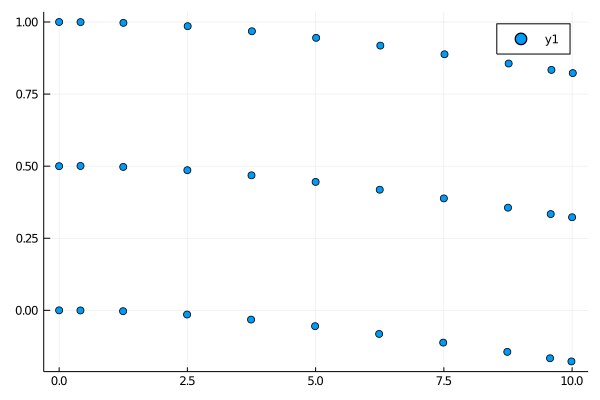

In [11]:
#反復する際の制御点の初期値(線形の場合の変位の係数(各制御点での変位)を加えたもの)
for I in 1:N   
    a[1,I] += uc1[I]
    a[2,I] += uc2[I]
end
plot(a[1,:],a[2,:], seriestype=:scatter)

In [17]:
# クロネッカーのデルタ
δ = [1.0 0.0
     0.0 1.0]

# 弾性定数
C = zeros(Float64,(2,2,2,2))
for i in 1:2
    for j in 1:2
        for k in 1:2
            for l in 1:2
                C[i,j,k,l] = λ*δ[i,j]*δ[k,l]+μ*(δ[i,k]*δ[j,l]+δ[i,l]*δ[j,k])
            end
        end
    end
end

nip1 = 4    # 積分点の数 (被積分関数のt1の最大次数12+1)/2以上
nip2 = 4    # 積分点の数 (被積分関数のt2の最大次数8+1)/2以上

4

In [26]:
Ṙ = zeros(Float64,(N,2))
Q = zeros(Float64,(2,2))

# Fの第1項の被積分関数
function F1_0(I,i,a,t1,t2)
    # NURBS基底関数RᴵをXᵢで微分した関数
    for J in 1:N
        J1 = div(J-1,N2)+1
        J2 = (J-1)%N2+1
        Ṙ[J,1] = Ḃs(J1,p1,k1,t1)*Bs(J2,p2,k2,t2)/10 # Jinv11 = 1/10で一定
        Ṙ[J,2] = Bs(J1,p1,k1,t1)*Ḃs(J2,p2,k2,t2) # Jinv22 = 1で一定
    end
    
    # テンソルQᵢⱼ
    for k in 1:2
        for l in 1:2
            Q[k,l] = sum(a[k,J]*Ṙ[J,l] for J in 1:N)
        end
    end
    @show Q
    
    ans = 0.0
    for p in 1:2
        for q in 1:2
            for r in 1:2
                for s in 1:2
                    tmp = sum(Q[k,r]*Q[k,s] for k in 1:2)
                    ans += C[p,q,r,s]*Ṙ[I,p]*Q[i,q]*(tmp-δ[r,s])
                end
            end
        end
    end
    return ans
end

# Hの被積分関数
function Hsub_0(I,M,i,m,a,t1,t2)
    # NURBS基底関数RᴵをXᵢで微分した関数
    for J in 1:N
        J1 = div(J-1,N2)+1
        J2 = (J-1)%N2+1
        Ṙ[J,1] = Ḃs(J1,p1,k1,t1)*Bs(J2,p2,k2,t2)/10 # Jinv11 = 1/10で一定
        Ṙ[J,2] = Bs(J1,p1,k1,t1)*Ḃs(J2,p2,k2,t2) # Jinv22 = 1で一定
    end
    
    # テンソルQᵢⱼ
    for k in 1:2
        for l in 1:2
            Q[k,l] = sum(a[k,J]*Ṙ[J,l] for J in 1:N)
        end
    end
    
    ans = 0.0
    for p in 1:2
        for q in 1:2 
            for r in 1:2
                for s in 1:2
                    tmp = sum(Q[k,r]*Q[k,s] for k in 1:2)
                    ans += C[p,q,r,s]*Ṙ[I,p]*(δ[i,m]*Ṙ[M,q]*(tmp-δ[r,s])+2*Ṙ[M,r]*Q[i,q]*Q[m,s])
                end
            end
        end
    end
    return ans
end

Hsub_0 (generic function with 1 method)

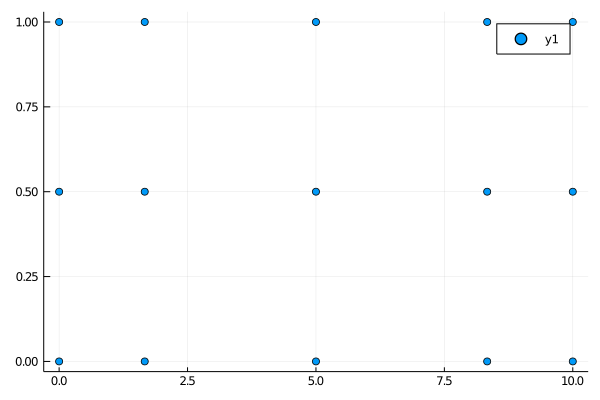

In [27]:
plot(a[1,:],a[2,:], seriestype=:scatter)

Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0

Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.998000568729993 4.437342591868191e-31; -0.00046427758026243524 0.9999999999999996]
Q = [0.9992106142539794 1.9721522630525295e-31; -0.00033398161780301416 0.9999999999999997]
Q = [1.0007893857460206 -3.944304526105059e-31; -0.00033398161780284763 0.9999999999999997]
Q = [1.001999431270007 0.0; -0.00046427758026212906 0.9999999999999997]
Q = [0.998000568729993 4.437342591868191e-31; -0.00046427758026243524 0.9999999999999996]
Q = [0.9992106142539794 1.9721522630525295e-31; -0.00033398161780301416 0.9999999999999997]
Q = [1.0007893857460206 -3.944304526105059e-31; -0.00033398161780284763 0.9999999999999997]
Q = [1.001999431270007 0.

Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.9976781477646602 0.0; -0.000518072995350825 0.9999999999999997]
Q = [0.998000568729993 4.437342591868191e-31; -0.00046427758026243524 0.9999999999999996]
Q = [0.9992106142539794 1.9721522630525295e-31; -0.00033398161780301416 0.9999999999999997]
Q = [1.0007893857460206 -3.944304526105059e-31; -0.00033398161780284763 0.9999999999999997]
Q = [1.001999431270007 0.0; -0.00046427758026212906 0.9999999999999997]
Q = [0.998000568729993 4.437342591868191e-31; -0.00046427758026243524 0.99999999999999

Q = [0.9981900941515013 0.012816275000923305; -0.013188316469798839 1.0009517180776721]
Q = [0.9981900941515013 0.012816275000923305; -0.013188316469798839 1.0009517180776721]
Q = [0.9980334619885493 0.0010658961403923624; -0.001414703167610126 1.0001581201266878]
Q = [0.999223600681587 0.0010658961403923785; -0.0012966856001934172 1.000062426639034]
Q = [1.0007763993184131 0.001065896140392323; -0.0012966856001932845 0.999937573360965]
Q = [1.0019665380114506 0.0010658961403923264; -0.0014147031676098008 0.9998418798733113]
Q = [0.9981569103512953 0.004908507926533842; -0.004981649338944606 1.0006120768030655]
Q = [0.9992723387299427 0.004908507926533995; -0.0049097125744553115 1.0002416510690104]
Q = [1.0007276612700573 0.004908507926533967; -0.004909712574455251 0.9997583489309897]
Q = [1.0018430896487047 0.004908507926533856; -0.0049816493389444605 0.9993879231969343]
Q = [0.9983179759905453 0.009547617918454016; -0.009635517988776265 1.0008732162692766]
Q = [0.9993359282724814 0.0

Q = [1.0021402995366586 0.004908507926533967; -0.005011349937741022 0.9992892219328988]
Q = [1.0021402995366586 0.004908507926533967; -0.005011349937741022 0.9992892219328988]
Q = [1.0019532610421933 0.009547617918454154; -0.009640395722386064 0.9989859720725746]
Q = [1.0019532610421933 0.009547617918454154; -0.009640395722386064 0.9989859720725746]
Q = [1.0019532610421933 0.009547617918454154; -0.009640395722386064 0.9989859720725746]
Q = [1.0019532610421933 0.009547617918454154; -0.009640395722386064 0.9989859720725746]
Q = [1.0018099058484986 0.012816275000923305; -0.013188316469798844 0.9990482819223279]
Q = [1.0018099058484986 0.012816275000923305; -0.013188316469798844 0.9990482819223279]
Q = [1.0018099058484986 0.012816275000923305; -0.013188316469798844 0.9990482819223279]
Q = [1.0018099058484986 0.012816275000923305; -0.013188316469798844 0.9990482819223279]
Q = [0.998000568729993 4.437342591868191e-31; -0.00046427758026243524 0.9999999999999996]
Q = [0.9992106142539794 1.9721

Q = [1.0021402995366586 0.004908507926533967; -0.005011349937741022 0.9992892219328988]
Q = [1.0021402995366586 0.004908507926533967; -0.005011349937741022 0.9992892219328988]
Q = [1.0019532610421933 0.009547617918454154; -0.009640395722386064 0.9989859720725746]
Q = [1.0019532610421933 0.009547617918454154; -0.009640395722386064 0.9989859720725746]
Q = [1.0019532610421933 0.009547617918454154; -0.009640395722386064 0.9989859720725746]
Q = [1.0019532610421933 0.009547617918454154; -0.009640395722386064 0.9989859720725746]
Q = [1.0018099058484986 0.012816275000923305; -0.013188316469798844 0.9990482819223279]
Q = [1.0018099058484986 0.012816275000923305; -0.013188316469798844 0.9990482819223279]
Q = [1.0018099058484986 0.012816275000923305; -0.013188316469798844 0.9990482819223279]
Q = [1.0018099058484986 0.012816275000923305; -0.013188316469798844 0.9990482819223279]
Q = [1.0022836547303533 0.001065896140392323; -0.0014634291903280992 0.9998163820006659]
Q = [1.0022836547303533 0.00106

Q = [0.9982893506783879 0.014451156979053033; -0.014758488196652448 1.0008253608308064]
Q = [0.9982893506783879 0.014451156979053033; -0.014758488196652448 1.0008253608308064]
Q = [0.9982893506783879 0.014451156979053033; -0.014758488196652448 1.0008253608308064]
Q = [0.9985185051196115 0.017223828257581175; -0.01710342019225969 1.0006152981566299]
Q = [0.9985185051196115 0.017223828257581175; -0.01710342019225969 1.0006152981566299]
Q = [0.9985185051196115 0.017223828257581175; -0.01710342019225969 1.0006152981566299]
Q = [0.9985185051196115 0.017223828257581175; -0.01710342019225969 1.0006152981566299]
Q = [0.998817487671843 0.020242868093844457; -0.020162901601888265 1.0004359335159747]
Q = [0.998817487671843 0.020242868093844457; -0.020162901601888265 1.0004359335159747]
Q = [0.998817487671843 0.020242868093844457; -0.020162901601888265 1.0004359335159747]
Q = [0.998817487671843 0.020242868093844457; -0.020162901601888265 1.0004359335159747]
Q = [0.9990466421130664 0.02209806811781

Q = [1.0019665380114506 0.0010658961403923264; -0.0014147031676098008 0.9998418798733113]
Q = [0.9981569103512953 0.004908507926533842; -0.004981649338944606 1.0006120768030655]
Q = [0.9992723387299427 0.004908507926533995; -0.0049097125744553115 1.0002416510690104]
Q = [1.0007276612700573 0.004908507926533967; -0.004909712574455251 0.9997583489309897]
Q = [1.0018430896487047 0.004908507926533856; -0.0049816493389444605 0.9993879231969343]
Q = [0.9983179759905453 0.009547617918454016; -0.009635517988776265 1.0008732162692766]
Q = [0.9993359282724814 0.00954761791845371; -0.009623703803603178 1.0003447502729903]
Q = [1.0006640717275186 0.00954761791845371; -0.00962370380360314 0.9996552497270098]
Q = [1.0016820240094548 0.00954761791845371; -0.009635517988776238 0.9991267837307234]
Q = [0.9984414243532911 0.012816275000922694; -0.013202464160110748 1.000819558995084]
Q = [0.9993846663208369 0.012816275000923527; -0.013236730777865056 1.0003235661052456]
Q = [1.0006153336791628 0.0128162

Q = [1.0017106493216115 0.014451156979053026; -0.01475848819665252 0.9991746391691937]
Q = [1.0017106493216115 0.014451156979053026; -0.01475848819665252 0.9991746391691937]
Q = [1.0017106493216115 0.014451156979053026; -0.01475848819665252 0.9991746391691937]
Q = [1.0014814948803887 0.017223828257582063; -0.017103420192259702 0.9993847018433701]
Q = [1.0014814948803887 0.017223828257582063; -0.017103420192259702 0.9993847018433701]
Q = [1.0014814948803887 0.017223828257582063; -0.017103420192259702 0.9993847018433701]
Q = [1.0014814948803887 0.017223828257582063; -0.017103420192259702 0.9993847018433701]
Q = [1.0011825123281572 0.020242868093845345; -0.020162901601888245 0.9995640664840251]
Q = [1.0011825123281572 0.020242868093845345; -0.020162901601888245 0.9995640664840251]
Q = [1.0011825123281572 0.020242868093845345; -0.020162901601888245 0.9995640664840251]
Q = [1.0011825123281572 0.020242868093845345; -0.020162901601888245 0.9995640664840251]
Q = [1.0009533578869343 0.022098068

Q = [1.000402031775379 0.02024286809384579; -0.020187435558359376 0.9998517908683052]
Q = [1.0010183043046839 0.0202428680938449; -0.020170070945665836 0.9996246018199533]
Q = [0.9991790289056164 0.022098068117809677; -0.0225103172461823 1.00031952378062]
Q = [0.9996758763906906 0.022098068117810232; -0.022516332803372924 1.0001261496315077]
Q = [1.00032412360931 0.022098068117809788; -0.022516332803372896 0.9998738503684925]
Q = [1.0008209710943838 0.022098068117809788; -0.0225103172461823 0.9996804762193798]
Q = [1.0017106493216115 0.014451156979053026; -0.01475848819665252 0.9991746391691937]
Q = [1.0017106493216115 0.014451156979053026; -0.01475848819665252 0.9991746391691937]
Q = [1.0017106493216115 0.014451156979053026; -0.01475848819665252 0.9991746391691937]
Q = [1.0017106493216115 0.014451156979053026; -0.01475848819665252 0.9991746391691937]
Q = [1.0014814948803887 0.017223828257582063; -0.017103420192259702 0.9993847018433701]
Q = [1.0014814948803887 0.017223828257582063; -0

Q = [1.0005036801755 0.017223828257582063; -0.017148875020398455 0.9997908102905931]
Q = [1.0012757690369436 0.017223828257581175; -0.017116703059605595 0.9994701444148693]
Q = [0.9989816956953161 0.02024286809384518; -0.020170070945665818 1.0003753981800467]
Q = [0.9995979682246212 0.02024286809384468; -0.020187435558359373 1.0001482091316947]
Q = [1.000402031775379 0.02024286809384579; -0.020187435558359376 0.9998517908683052]
Q = [1.0010183043046839 0.0202428680938449; -0.020170070945665836 0.9996246018199533]
Q = [0.9991790289056164 0.022098068117809677; -0.0225103172461823 1.00031952378062]
Q = [0.9996758763906906 0.022098068117810232; -0.022516332803372924 1.0001261496315077]
Q = [1.00032412360931 0.022098068117809788; -0.022516332803372896 0.9998738503684925]
Q = [1.0008209710943838 0.022098068117809788; -0.0225103172461823 0.9996804762193798]
Q = [1.0017106493216115 0.014451156979053026; -0.01475848819665252 0.9991746391691937]
Q = [1.0017106493216115 0.014451156979053026; -0.0

Q = [1.0022836547303533 0.001065896140392323; -0.0014634291903280992 0.9998163820006659]
Q = [1.0022836547303533 0.001065896140392323; -0.0014634291903280992 0.9998163820006659]
Q = [1.0021402995366586 0.004908507926533967; -0.005011349937741022 0.9992892219328988]
Q = [1.0021402995366586 0.004908507926533967; -0.005011349937741022 0.9992892219328988]
Q = [1.0021402995366586 0.004908507926533967; -0.005011349937741022 0.9992892219328988]
Q = [1.0021402995366586 0.004908507926533967; -0.005011349937741022 0.9992892219328988]
Q = [1.0019532610421933 0.009547617918454154; -0.009640395722386064 0.9989859720725746]
Q = [1.0019532610421933 0.009547617918454154; -0.009640395722386064 0.9989859720725746]
Q = [1.0019532610421933 0.009547617918454154; -0.009640395722386064 0.9989859720725746]
Q = [1.0019532610421933 0.009547617918454154; -0.009640395722386064 0.9989859720725746]
Q = [1.0018099058484986 0.012816275000923305; -0.013188316469798844 0.9990482819223279]
Q = [1.0018099058484986 0.0128

Q = [0.9985185051196115 0.017223828257581175; -0.01710342019225969 1.0006152981566299]
Q = [0.998817487671843 0.020242868093844457; -0.020162901601888265 1.0004359335159747]
Q = [0.998817487671843 0.020242868093844457; -0.020162901601888265 1.0004359335159747]
Q = [0.998817487671843 0.020242868093844457; -0.020162901601888265 1.0004359335159747]
Q = [0.998817487671843 0.020242868093844457; -0.020162901601888265 1.0004359335159747]
Q = [0.9990466421130664 0.022098068117810676; -0.022507833597495502 1.0003710490154907]
Q = [0.9990466421130664 0.022098068117810676; -0.022507833597495502 1.0003710490154907]
Q = [0.9990466421130664 0.022098068117810676; -0.022507833597495502 1.0003710490154907]
Q = [0.9990466421130664 0.022098068117810676; -0.022507833597495502 1.0003710490154907]
Q = [0.9982893506783879 0.014451156979053033; -0.014758488196652448 1.0008253608308064]
Q = [0.9982893506783879 0.014451156979053033; -0.014758488196652448 1.0008253608308064]
Q = [0.9982893506783879 0.01445115697

Q = [0.9981900941515013 0.012816275000923305; -0.013188316469798839 1.0009517180776721]
Q = [0.9981900941515013 0.012816275000923305; -0.013188316469798839 1.0009517180776721]
Q = [0.9981900941515013 0.012816275000923305; -0.013188316469798839 1.0009517180776721]
Q = [0.9981900941515013 0.012816275000923305; -0.013188316469798839 1.0009517180776721]
Q = [0.9980334619885493 0.0010658961403923624; -0.001414703167610126 1.0001581201266878]
Q = [0.999223600681587 0.0010658961403923785; -0.0012966856001934172 1.000062426639034]
Q = [1.0007763993184131 0.001065896140392323; -0.0012966856001932845 0.999937573360965]
Q = [1.0019665380114506 0.0010658961403923264; -0.0014147031676098008 0.9998418798733113]
Q = [0.9981569103512953 0.004908507926533842; -0.004981649338944606 1.0006120768030655]
Q = [0.9992723387299427 0.004908507926533995; -0.0049097125744553115 1.0002416510690104]
Q = [1.0007276612700573 0.004908507926533967; -0.004909712574455251 0.9997583489309897]
Q = [1.0018430896487047 0.00

Q = [0.9981900941515013 0.012816275000923305; -0.013188316469798839 1.0009517180776721]
Q = [0.9981900941515013 0.012816275000923305; -0.013188316469798839 1.0009517180776721]
Q = [0.9981900941515013 0.012816275000923305; -0.013188316469798839 1.0009517180776721]
Q = [0.9980334619885493 0.0010658961403923624; -0.001414703167610126 1.0001581201266878]
Q = [0.999223600681587 0.0010658961403923785; -0.0012966856001934172 1.000062426639034]
Q = [1.0007763993184131 0.001065896140392323; -0.0012966856001932845 0.999937573360965]
Q = [1.0019665380114506 0.0010658961403923264; -0.0014147031676098008 0.9998418798733113]
Q = [0.9981569103512953 0.004908507926533842; -0.004981649338944606 1.0006120768030655]
Q = [0.9992723387299427 0.004908507926533995; -0.0049097125744553115 1.0002416510690104]
Q = [1.0007276612700573 0.004908507926533967; -0.004909712574455251 0.9997583489309897]
Q = [1.0018430896487047 0.004908507926533856; -0.0049816493389444605 0.9993879231969343]
Q = [0.9983179759905453 0.0

Q = [1.0001284616482968 0.025361850385787754; -0.02535635467843797 0.9999359423044912]
Q = [1.0003253798765628 0.025361850385788642; -0.025334684624744308 0.9998377485783974]
Q = [0.9998469192448493 0.02584445357608378; -0.02619063606566486 1.0000413153315784]
Q = [0.999939562930759 0.025844453576081783; -0.02621957069602871 1.000016311505341]
Q = [1.0000604370692394 0.025844453576084447; -0.02621957069602876 0.9999836884946589]
Q = [1.0001530807551502 0.025844453576084447; -0.02619063606566502 0.9999586846684214]
Q = [1.0008389859137485 0.022925913608096538; -0.023359921274693204 0.9996414670244221]
Q = [1.0008389859137485 0.022925913608096538; -0.023359921274693204 0.9996414670244221]
Q = [1.0008389859137485 0.022925913608096538; -0.023359921274693204 0.9996414670244221]
Q = [1.0008389859137485 0.022925913608096538; -0.023359921274693204 0.9996414670244221]
Q = [1.0006389024669204 0.024209595799955963; -0.02421287338309397 0.9996889756849736]
Q = [1.0006389024669204 0.024209595799955

Q = [1.0009533578869343 0.022098068117809788; -0.022507833597495447 0.9996289509845095]
Q = [0.9991610140862516 0.022925913608098328; -0.023359921274693194 1.0003585329755782]
Q = [0.9991610140862516 0.022925913608098328; -0.023359921274693194 1.0003585329755782]
Q = [0.9991610140862516 0.022925913608098328; -0.023359921274693194 1.0003585329755782]
Q = [0.9991610140862516 0.022925913608098328; -0.023359921274693194 1.0003585329755782]
Q = [0.9993610975330791 0.02420959579995552; -0.024212873383093955 1.0003110243150266]
Q = [0.9993610975330791 0.02420959579995552; -0.024212873383093955 1.0003110243150266]
Q = [0.9993610975330791 0.02420959579995552; -0.024212873383093955 1.0003110243150266]
Q = [0.9993610975330791 0.02420959579995552; -0.024212873383093955 1.0003110243150266]
Q = [0.999622150555977 0.025361850385788642; -0.025325737689540433 1.0001884154917382]
Q = [0.999622150555977 0.025361850385788642; -0.025325737689540433 1.0001884154917382]
Q = [0.999622150555977 0.0253618503857

Q = [1.0014814948803887 0.017223828257582063; -0.017103420192259702 0.9993847018433701]
Q = [1.0014814948803887 0.017223828257582063; -0.017103420192259702 0.9993847018433701]
Q = [1.0014814948803887 0.017223828257582063; -0.017103420192259702 0.9993847018433701]
Q = [1.0011825123281572 0.020242868093845345; -0.020162901601888245 0.9995640664840251]
Q = [1.0011825123281572 0.020242868093845345; -0.020162901601888245 0.9995640664840251]
Q = [1.0011825123281572 0.020242868093845345; -0.020162901601888245 0.9995640664840251]
Q = [1.0011825123281572 0.020242868093845345; -0.020162901601888245 0.9995640664840251]
Q = [1.0009533578869343 0.022098068117809788; -0.022507833597495447 0.9996289509845095]
Q = [1.0009533578869343 0.022098068117809788; -0.022507833597495447 0.9996289509845095]
Q = [1.0009533578869343 0.022098068117809788; -0.022507833597495447 0.9996289509845095]
Q = [1.0009533578869343 0.022098068117809788; -0.022507833597495447 0.9996289509845095]
Q = [1.0017106493216115 0.014451

Q = [1.0019532610421933 0.009547617918454154; -0.009640395722386064 0.9989859720725746]
Q = [1.0018099058484986 0.012816275000923305; -0.013188316469798844 0.9990482819223279]
Q = [1.0018099058484986 0.012816275000923305; -0.013188316469798844 0.9990482819223279]
Q = [1.0018099058484986 0.012816275000923305; -0.013188316469798844 0.9990482819223279]
Q = [1.0018099058484986 0.012816275000923305; -0.013188316469798844 0.9990482819223279]
Q = [1.0022836547303533 0.001065896140392323; -0.0014634291903280992 0.9998163820006659]
Q = [1.0022836547303533 0.001065896140392323; -0.0014634291903280992 0.9998163820006659]
Q = [1.0022836547303533 0.001065896140392323; -0.0014634291903280992 0.9998163820006659]
Q = [1.0022836547303533 0.001065896140392323; -0.0014634291903280992 0.9998163820006659]
Q = [1.0021402995366586 0.004908507926533967; -0.005011349937741022 0.9992892219328988]
Q = [1.0021402995366586 0.004908507926533967; -0.005011349937741022 0.9992892219328988]
Q = [1.0021402995366586 0.00

Q = [1.000377849444022 0.025361850385786866; -0.025325737689540495 0.9998115845082618]
Q = [1.000377849444022 0.025361850385786866; -0.025325737689540495 0.9998115845082618]
Q = [1.000377849444022 0.025361850385786866; -0.025325737689540495 0.9998115845082618]
Q = [1.0001777659971953 0.025844453576084447; -0.0261786897979413 0.9999520223093346]
Q = [1.0001777659971953 0.025844453576084447; -0.0261786897979413 0.9999520223093346]
Q = [1.0001777659971953 0.025844453576084447; -0.0261786897979413 0.9999520223093346]
Q = [1.0001777659971953 0.025844453576084447; -0.0261786897979413 0.9999520223093346]
Q = [1.0008389859137485 0.022925913608096538; -0.023359921274693204 0.9996414670244221]
Q = [1.0008389859137485 0.022925913608096538; -0.023359921274693204 0.9996414670244221]
Q = [1.0008389859137485 0.022925913608096538; -0.023359921274693204 0.9996414670244221]
Q = [1.0008389859137485 0.022925913608096538; -0.023359921274693204 0.9996414670244221]
Q = [1.0006389024669204 0.02420959579995596

Q = [1.0001530807551502 0.025844453576084447; -0.02619063606566502 0.9999586846684214]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.026405961943262

Q = [0.9998928289630782 0.025914398994470123; -0.026418707393882777 1.00000323297811]
Q = [0.9999576883235733 0.025914398994470567; -0.026449577696728635 1.000001276396381]
Q = [1.0000423116764252 0.025914398994471455; -0.026449577696728677 0.9999987236036189]
Q = [1.0001071710369205 0.02591439899446968; -0.026418707393882912 0.9999967670218898]
Q = [0.9998928289630782 0.025914398994470123; -0.026418707393882777 1.00000323297811]
Q = [0.9999576883235733 0.025914398994470567; -0.026449577696728635 1.000001276396381]
Q = [1.0000423116764252 0.025914398994471455; -0.026449577696728677 0.9999987236036189]
Q = [1.0001071710369205 0.02591439899446968; -0.026418707393882912 0.9999967670218898]
Q = [0.9998928289630782 0.025914398994470123; -0.026418707393882777 1.00000323297811]
Q = [0.9999576883235733 0.025914398994470567; -0.026449577696728635 1.000001276396381]
Q = [1.0000423116764252 0.025914398994471455; -0.026449577696728677 0.9999987236036189]
Q = [1.0001071710369205 0.02591439899446968

Q = [1.000377849444022 0.025361850385786866; -0.025325737689540495 0.9998115845082618]
Q = [1.000377849444022 0.025361850385786866; -0.025325737689540495 0.9998115845082618]
Q = [1.0001777659971953 0.025844453576084447; -0.0261786897979413 0.9999520223093346]
Q = [1.0001777659971953 0.025844453576084447; -0.0261786897979413 0.9999520223093346]
Q = [1.0001777659971953 0.025844453576084447; -0.0261786897979413 0.9999520223093346]
Q = [1.0001777659971953 0.025844453576084447; -0.0261786897979413 0.9999520223093346]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.026405961

Q = [0.9992775187647552 0.022925913608097422; -0.023361955586030915 1.000308745764174]
Q = [0.9997147606934913 0.02292591360809655; -0.023366882819202267 1.0001218944151966]
Q = [1.0002852393065096 0.022925913608098328; -0.023366882819202243 0.9998781055848035]
Q = [1.0007224812352447 0.02292591360809479; -0.02336195558603094 0.999691254235826]
Q = [0.9994498178861675 0.024209595799955547; -0.024217907026951542 1.0002678343314582]
Q = [0.9997827852725476 0.024209595799955186; -0.02423009883679307 1.000105742371203]
Q = [1.0002172147274526 0.02420959579995663; -0.024230098836793057 0.9998942576287972]
Q = [1.0005501821138325 0.024209595799954187; -0.024217907026951563 0.9997321656685418]
Q = [0.999674620123436 0.025361850385786866; -0.025334684624744225 1.0001622514216026]
Q = [0.9998715383517032 0.02536185038578731; -0.025356354678437942 1.0000640576955087]
Q = [1.0001284616482968 0.025361850385787754; -0.02535635467843797 0.9999359423044912]
Q = [1.0003253798765628 0.02536185038578864

Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405

Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405

Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289

Q = [0.9999576883235733 0.025914398994470567; -0.026449577696728635 1.000001276396381]
Q = [1.0000423116764252 0.025914398994471455; -0.026449577696728677 0.9999987236036189]
Q = [1.0001071710369205 0.02591439899446968; -0.026418707393882912 0.9999967670218898]
Q = [0.9998928289630782 0.025914398994470123; -0.026418707393882777 1.00000323297811]
Q = [0.9999576883235733 0.025914398994470567; -0.026449577696728635 1.000001276396381]
Q = [1.0000423116764252 0.025914398994471455; -0.026449577696728677 0.9999987236036189]
Q = [1.0001071710369205 0.02591439899446968; -0.026418707393882912 0.9999967670218898]
Q = [0.9998928289630782 0.025914398994470123; -0.026418707393882777 1.00000323297811]
Q = [0.9999576883235733 0.025914398994470567; -0.026449577696728635 1.000001276396381]
Q = [1.0000423116764252 0.025914398994471455; -0.026449577696728677 0.9999987236036189]
Q = [1.0001071710369205 0.02591439899446968; -0.026418707393882912 0.9999967670218898]
Q = [0.9998755469540903 0.0259143989944696

Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998928289630782 0.025914398994470123; -0.026418707393882777 1.00000323297811]
Q = [0.9999576883235733 0.025914398994470567; -0.026449577696728635 1.000001276396381]
Q = [1.0000423116764252 0.025914398994471455; -0.026449577696728677 0.9999987236036189]
Q = [1.0001071710369205 0.02591439899446968; -0.026418707393882912 0.9999967670218898]
Q = [0.9998928289630782 0.025914398994470123; -0.026418707393882777 1.00000323297811]
Q = [0.9999576883235733 0.025914398994470567; -0.026449577696728635 1.000001276396381]
Q = [1.0000423116764252 0.025914398994471455; -0.02644

Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289 1.000003754316322]
Q = [0.9998755469540903 0.02591439899446968; -0.02640596194326289

Q = [0.9992775187647552 0.022925913608097422; -0.023361955586030915 1.000308745764174]
Q = [0.9997147606934913 0.02292591360809655; -0.023366882819202267 1.0001218944151966]
Q = [1.0002852393065096 0.022925913608098328; -0.023366882819202243 0.9998781055848035]
Q = [1.0007224812352447 0.02292591360809479; -0.02336195558603094 0.999691254235826]
Q = [0.9994498178861675 0.024209595799955547; -0.024217907026951542 1.0002678343314582]
Q = [0.9997827852725476 0.024209595799955186; -0.02423009883679307 1.000105742371203]
Q = [1.0002172147274526 0.02420959579995663; -0.024230098836793057 0.9998942576287972]
Q = [1.0005501821138325 0.024209595799954187; -0.024217907026951563 0.9997321656685418]
Q = [0.999674620123436 0.025361850385786866; -0.025334684624744225 1.0001622514216026]
Q = [0.9998715383517032 0.02536185038578731; -0.025356354678437942 1.0000640576955087]
Q = [1.0001284616482968 0.025361850385787754; -0.02535635467843797 0.9999359423044912]
Q = [1.0003253798765628 0.02536185038578864

Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
Q = [1.0001244530459088 0.02591439899446968; -0.026405961943263057 0.999996245683678]
ν=1: Fnorm=539.5321700040805, anorm=0.0036514529642670867


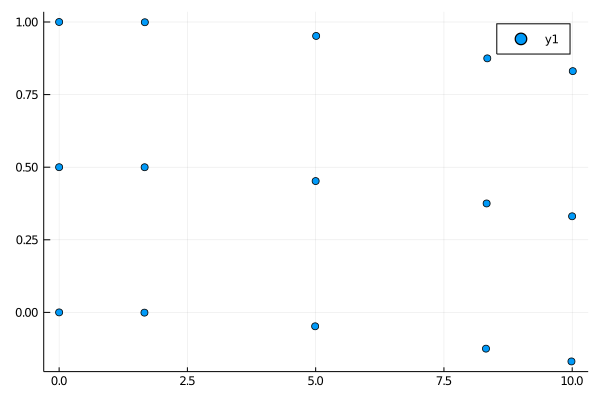

In [29]:
# 反復式
F = zeros(Float64,2N)
a1 = zeros(Float64,2N)
a1tmp = zeros(Float64,2N)
Hsub = zeros(Float64,(N,N,2,2))
H = zeros(Float64,(2N,2N))
Δa1 = zeros(Float64,2N)
for ν in 1:1
    a1tmp = copy(a1)   # Δaノルムを求めるために一時的にa1を保存しておく
    
    # Fを求める
    for I in 1:N
        I1 = div(I-1,N2)+1
        I2 = (I-1)%N2+1
        for i in 1:2
            idx = 2*(I-1)+i   # Iとiをまとめた通し番号(1~2N)
            
            F1_2 = sum(INT(t1->INT(t2->F1_0(I,i,a,t1,t2),k2[n2],k2[n2+1],nip2),k1[n1],k1[n1+1],nip1)
                        for n1 in I1:I1+p1 for n2 in I2:I2+p2) # パラメータ空間上で積分
            F[idx] = 1/2*F1_2*detJ-b[idx]   
        end
    end
    
    # 勾配Hの部分行列Hsubを作る
    for I in 1:N
        I1 = div(I-1,N2)+1
        I2 = (I-1)%N2+1
        for i in 1:2
            for M in 1:N
                for m in 1:2
                    Hsub_2 = sum(INT(t1->INT(t2->Hsub_0(I,M,i,m,a,t1,t2),k2[n2],k2[n2+1],nip2),k1[n1],k1[n1+1],nip1)
                                for n1 in I1:I1+p1 for n2 in I2:I2+p2) # パラメータ空間上で積分
                    Hsub[I,M,i,m] = 1/2*Hsub_2*detJ
                end
            end
        end
    end
    
    # H(2N*2N)を作る
    for idx1 in 1:2N
        for idx2 in 1:2N
            I = div(idx1-1,2)+1
            J = div(idx2-1,2)+1
            i = (idx1-1)%2+1
            j = (idx2-1)%2+1
            if i==1 && j==1
                H[idx1,idx2] = Hsub[I,J,1,1]
            elseif i==1 && j==2
                H[idx1,idx2] = Hsub[I,J,1,2]
            elseif i==2 && j==1
                H[idx1,idx2] = Hsub[I,J,2,1]
            elseif i==2 && j==2
                H[idx1,idx2] = Hsub[I,J,2,2]
            end
        end
    end

    # Dirichlet境界条件を負荷
    # H
    H[1:2N2,:] .= 0.0
    H[:,1:2N2] .= 0.0
    for i in 1:2N2
        H[i,i] = 1.0
    end
    # F
    F[1:2N2] .= 0.0
    
    # H Δa1=Fを解く
    Δa1 = H\F

    # 制御点aの配列(2*N)の形をa1(2N*1)に変更する
    for idx in 1:2N
        I = div(idx-1,2)+1
        i = (idx-1)%2+1
        a1[idx] = a[i,I]
    end
    
    # 制御点aを更新
    for idx in 1:2N
        a1[idx] -= Δa1[idx]
    end
    
    # 収束判定
    Fnorm = sqrt(sum(F[idx]^2 for idx in 1:2N))
    anorm = sqrt(sum(Δa1[idx]^2 for idx in 1:2N))
    println("ν=",ν,": Fnorm=",Fnorm,", anorm=",anorm)
    if Fnorm<1.0e-5 && anorm<1.0e-5
        break
    end
    
    # 制御点aの配列の形を行列(2*N)に戻す
    for idx in 1:2N
        I = div(idx-1,2)+1
        i = (idx-1)%2+1
        a[i,I] = a1[idx]
    end 
    
end

plot(a[1,:],a[2,:], seriestype=:scatter)

In [21]:
println(F)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.6792567336665343e-8, -6.372137824339763e-8, -1.6704127230732224e-8, 2.2064527982479376e-9, -5.798757030106572e-9, 6.699270554966219e-8, -8.401720208439656e-8, -2.839068753701657e-7, -3.598046032177258e-8, 1.149422890200924e-8, 3.6953831106245616e-8, 3.015173868914367e-7, -1.1221131801519846e-7, -3.2455162446431984e-7, -2.0054036521666152e-8, 1.0600974542640529e-8, 8.618813218674859e-8, 3.395736725142484e-7, -1.0688302095237155e-8, -2.2075043659697258e-7, 5.753121596017523e-8, -1.971670471334619e-8, 1.2953958942555727e-7, 1.8004513746561202e-7]


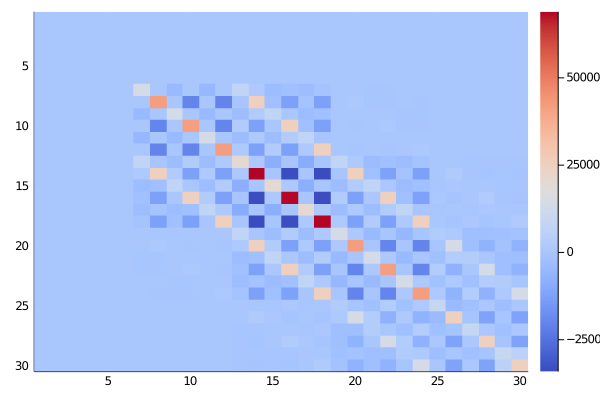

In [22]:
heatmap(H,yflip=true,color=:coolwarm)

In [23]:
H

30×30 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0       0.0       …       0.0        0.0
 0.0  1.0  0.0  0.0  0.0  0.0       0.0               0.0        0.0
 0.0  0.0  1.0  0.0  0.0  0.0       0.0               0.0        0.0
 0.0  0.0  0.0  1.0  0.0  0.0       0.0               0.0        0.0
 0.0  0.0  0.0  0.0  1.0  0.0       0.0               0.0        0.0
 0.0  0.0  0.0  0.0  0.0  1.0       0.0       …       0.0        0.0
 0.0  0.0  0.0  0.0  0.0  0.0       1.3959e5          0.0        0.0
 0.0  0.0  0.0  0.0  0.0  0.0    2786.8               0.0        0.0
 0.0  0.0  0.0  0.0  0.0  0.0  -47140.1               0.0        0.0
 0.0  0.0  0.0  0.0  0.0  0.0   -1512.58              0.0        0.0
 0.0  0.0  0.0  0.0  0.0  0.0  -54800.7       …       0.0        0.0
 0.0  0.0  0.0  0.0  0.0  0.0   -1467.19              0.0        0.0
 0.0  0.0  0.0  0.0  0.0  0.0   70516.6           -4001.28   -2955.81
 ⋮                        ⋮                   ⋱             
 0.0  0.0  0.0  0

In [20]:
inv(H)

66×66 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0   0.0         …   0.0           0.0
 0.0  1.0  0.0  0.0  0.0  0.0   0.0             0.0           0.0
 0.0  0.0  1.0  0.0  0.0  0.0   0.0             0.0           0.0
 0.0  0.0  0.0  1.0  0.0  0.0   0.0             0.0           0.0
 0.0  0.0  0.0  0.0  1.0  0.0   0.0             0.0           0.0
 0.0  0.0  0.0  0.0  0.0  1.0   0.0         …   0.0           0.0
 0.0  0.0  0.0  0.0  0.0  0.0   1.78324e-5     -2.0941e-9     7.34036e-5
 0.0  0.0  0.0  0.0  0.0  0.0   3.07605e-6      8.0312e-7     2.44489e-5
 0.0  0.0  0.0  0.0  0.0  0.0  -5.82756e-6      1.0634e-6     2.61549e-7
 0.0  0.0  0.0  0.0  0.0  0.0   9.55253e-8      1.14976e-6   -3.97339e-5
 0.0  0.0  0.0  0.0  0.0  0.0  -1.88525e-6  …   3.58788e-6   -7.31527e-5
 0.0  0.0  0.0  0.0  0.0  0.0   1.78144e-6     -1.79138e-6    2.46737e-5
 0.0  0.0  0.0  0.0  0.0  0.0  -3.11991e-7     -9.13089e-7    0.000239896
 ⋮                        ⋮                 ⋱                 ⋮
 0.0

In [19]:
println(F)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -4.025501903558757, -8.438612865286968, -1.906961416772612, 13.154708422264928, 1.4196840631183871, -3.33819512528456, -2.327346993550361, -12.75274265772812, -5.098478744511685, 1.9022869265881575, -4.429399911259864, 10.494717356286698, -6.807506221414772, -34.58618022849795, -9.457310551196306, -1.0120528958743655, -5.821915131553532, 35.995980372011566, -8.543557566305292, -65.9340040622529, -11.15081319286431, 0.6696433598229989, -6.360804943370075, 65.95809915505411, -9.315081629328613, -98.44724664861832, -10.99529733924387, 0.17518237635439846, -5.386318830089982, 98.9761132326874, -9.293550365156516, -128.80373946919048, -9.501510690988596, 0.4119350791979949, -3.417490143865314, 129.18755617008824, -8.406698268150265, -153.0478103494966, -6.91197510403518, 0.21803797659242147, -0.8381868550712956, 153.39577391962007, -5.430328048855979, -125.16330472004734, -3.263121837213241, 0.17210971595345792, 1.0629859375619954, 125.31414508476362, -2.97326

In [ ]:
# NURBS基底関数
function R(I,t1,t2)   # I:基底関数の通し番号
    I1 = div(I-1,N2)+1
    I2 = (I-1)%N2+1
    return Bs(I1,p1,k1,t1)*Bs(I2,p2,k2,t2)
end


# 形状表現
t1l = 100
t2l = 10
t3l = 1
t1 = collect(range(1.0e-10,1.0-1.0e-10,length=t1l))
t2 = collect(range(1.0e-10,1.0-1.0e-10,length=t2l))
X = zeros(Float64,(3,t1l,t2l,t3l)) # 参考状態の座標 X[次元,1軸方向の評価点,2軸方向の評価点,3軸方向の評価点]
x = zeros(Float64,(3,t1l,t2l,t3l)) # 現状態の座標 x[次元,1軸方向の評価点,2軸方向の評価点,3軸方向の評価点]
for d in 1:2
    for n1 in 1:t1l
        for n2 in 1:t2l
            for I in 1:N
                X[d,n1,n2,1] += R(I,t1[n1],t2[n2])*a0[d,I]
                x[d,n1,n2,1] += R(I,t1[n1],t2[n2])*a[d,I]
            end
        end
    end
end

# 第2Piola-Kirchhoff応力Sᵢⱼ, Cauchy応力σᵢⱼを求める
S = zeros(Float64,(2,2,t1l,t2l,t3l))
sigma = zeros(Float64,(2,2,t1l,t2l,t3l))
Ṙ = zeros(Float64,(N,2))
Q = zeros(Float64,(2,2))
for n1 in 1:t1l
    for n2 in 1:t2l
        
        # NURBS基底関数RᴵをXᵢで微分した関数
        for J in 1:N
            J1 = div(J-1,N2)+1
            J2 = (J-1)%N2+1
            Ṙ[J,1] = Ḃs(J1,p1,k1,t1[n1])*Bs(J2,p2,k2,t2[n2])/10 # Jinv11 = 1/10で一定
            Ṙ[J,2] = Bs(J1,p1,k1,t1[n1])*Ḃs(J2,p2,k2,t2[n2]) # Jinv22 = 1で一定
        end
        
        # テンソルQᵢⱼ
        for k in 1:2
            for l in 1:2
                Q[k,l] = sum(a[k,J]*Ṙ[J,l] for J in 1:N)
            end
        end
        detQ = Q[1,1]*Q[2,2]-Q[1,2]*Q[2,1]
        
        # 第2Piola-Kirchhoff応力テンソルSᵢⱼ
        for i in 1:2
             for j in 1:2
                for k in 1:2
                    for l in 1:2
                        tmp = sum(Q[m,k]*Q[m,l] for m in 1:2)
                        S[i,j,n1,n2,1] += C[i,j,k,l]/2*(tmp-δ[k,l])
                    end
                end
            end
        end
        
        # Cauchy応力σᵢⱼ
        for i in 1:2
             for j in 1:2
                for k in 1:2
                    for l in 1:2
                        sigma[i,j,n1,n2,1] += Q[i,k]*Q[j,l]*S[k,l,n1,n2,1]
                    end
                end
            end
        end
        sigma[:,:,n1,n2,1] ./= detQ
        
    end
end

In [124]:
# vtkファイルを作成

# 第2Piola-Kirchhoff応力
vtkfile = vtk_grid("hisenkei_2jigenIGA_sankoujoutai", X) # 参考状態
vtk_point_data(vtkfile, S[1,1,:,:,:], "S11")
vtk_point_data(vtkfile, S[1,2,:,:,:], "S12")
vtk_point_data(vtkfile, S[2,1,:,:,:], "S21")
vtk_point_data(vtkfile, S[2,2,:,:,:], "S22")
outfiles = vtk_save(vtkfile)

# Cauchy応力
vtkfile = vtk_grid("hisenkei_2jigenIGA_genjoutai", x) # 現状態
vtk_point_data(vtkfile, sigma[1,1,:,:,:], "sigma11")
vtk_point_data(vtkfile, sigma[1,2,:,:,:], "sigma12")
vtk_point_data(vtkfile, sigma[2,1,:,:,:], "sigma21")
vtk_point_data(vtkfile, sigma[2,2,:,:,:], "sigma22")
outfiles = vtk_save(vtkfile)

1-element Array{String,1}:
 "hisenkei_2jigenIGA_genjoutai.vts"

In [12]:
#=
# 1,2軸方向の各基底関数(N1,N2個)の台の両端の値を求める supp[基底関数の番号,1]:台の左端, supp[基底関数の番号,2]:台の右端
# 1軸方向のI1番目の基底関数の台の左端,右端
supp1 = zeros(Float64,N1,2)
for I1 in 1:N1
    supp1[I1,1] = k1[I1]
    supp1[I1,2] = k1[I1+p1+1]
end
supp2 = zeros(Float64,N2,2)
for I2 in 1:N2
    supp2[I2,1] = k2[I2]
    supp2[I2,2] = k2[I2+p2+1]
end
=#

#=
# NURBS基底関数
function R(I,t1,t2)   # I:基底関数の通し番号
    I1 = div(I-1,N2)+1
    I2 = (I-1)%N2+1
    if supp1[I1,1]<=t1<=supp1[I1,2] && supp2[I2,1]<=t2<=supp2[I2,2]
        return Bs(I1,p1,k1,t1)*Bs(I2,p2,k2,t2)
    else
        return 0.0
    end
end
=#

#=
# NURBS基底関数Rᴵをtᵢで微分した関数
function Ṙ(I,i,t1,t2)    # i:微分の方向(1or2)
    I1 = div(I-1,N2)+1
    I2 = (I-1)%N2+1
    if i == 1 && supp2[1]<=t2<=supp2[2]
        return Ḃs(I1,p1,k1,t1)*Bs(I2,p2,k2,t2)
    elseif i == 2 && supp1[1]<=t1<=supp1[2]
        return Bs(I1,p1,k1,t1)*Ḃs(I2,p2,k2,t2)
    else
        return 0.0
    end
end
=#